In [62]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import print_function
import sys
import libstempo 
import libstempo.plot as LP, libstempo.toasim as LT

import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc



In [63]:
datadir = '/Users/brendandrachler/Documents/code_dev/NANOGrav_12y/'

In [64]:
parfiles = sorted(glob.glob(datadir + 'par/*.par'))
timfiles = sorted(glob.glob(datadir + 'tim/*.tim'))

for parfile in parfiles:
    if 'J1713' in parfile and 't2' not in parfile:
        parfiles.remove(parfile)

In [65]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem='DE438')
    psrs.append(psr)

In [66]:
for psr in psrs:
    print(psr.name)

B1855+09
B1937+21
B1953+29
J0023+0923
J0030+0451
J0340+4130
J0613-0200
J0636+5128
J0645+5158
J0740+6620
J0931-1902
J1012+5307
J1022+1001
J1024-0719
J1125+7819
J1453+1902
J1455-3330
J1600-3053
J1614-2230
J1640+2224
J1643-1224
J1713+0747
J1738+0333
J1741+1351
J1744-1134
J1747-4036
J1832-0836
J1853+1303
J1903+0327
J1909-3744
J1910+1256
J1911+1347
J1918-0642
J1923+2515
J1944+0907
J1946+3417
J2010-1323
J2017+0603
J2033+1734
J2043+1711
J2145-0750
J2214+3000
J2229+2643
J2234+0611
J2234+0944
J2302+4442
J2317+1439
J2322+2057


In [67]:
def get_noise_from_enterprise(noisefile):
    
    with open(noisefile) as f:
        params = json.load(f)
    
    return params

get_noise_from_enterprise('/Users/brendandrachler/Documents/code_dev/NANOGrav_12y/channelized_12p5yr_v3_full_noisedict.json')

{'B1855+09_430_ASP_efac': 1.149036589204419,
 'B1855+09_430_ASP_log10_ecorr': -7.415374510054153,
 'B1855+09_430_ASP_log10_equad': -7.379759355541006,
 'B1855+09_430_PUPPI_efac': 1.0543836580555548,
 'B1855+09_430_PUPPI_log10_ecorr': -5.671108063699219,
 'B1855+09_430_PUPPI_log10_equad': -6.348065001180634,
 'B1855+09_L-wide_ASP_efac': 1.080749375878354,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.092899143243734,
 'B1855+09_L-wide_ASP_log10_equad': -6.51289896375955,
 'B1855+09_L-wide_PUPPI_efac': 1.2429537099744354,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641281263572077,
 'B1855+09_L-wide_PUPPI_log10_equad': -7.821737281350602,
 'B1855+09_red_noise_gamma': 4.223680673175877,
 'B1855+09_red_noise_log10_A': -14.029792598548077,
 'B1937+21_L-wide_ASP_efac': 2.048754020884262,
 'B1937+21_L-wide_ASP_log10_ecorr': -6.940958996081342,
 'B1937+21_L-wide_ASP_log10_equad': -6.785369742733748,
 'B1937+21_L-wide_PUPPI_efac': 2.12041666470792,
 'B1937+21_L-wide_PUPPI_log10_ecorr': -7.037572450266321

In [68]:
# cut down to pulsars that have been measured for 6 years
psrcut = []
for psr in psrs:
    tmax = max(psr.toas)
    tmin = min(psr.toas)
    Tspan = tmax - tmin
    if Tspan / 525600 / 60 > 7:
        psrcut.append(psr)
    # print(psr.name)
print(len(psrcut))

22


In [69]:
pickle.dump(psrcut, open("psrs.p", "wb"))

In [70]:
psrcut = pickle.load(open("psrs.p", "rb"))

In [ ]:
psrcut_parfiles = []
for psr in psrcut:
    for parfile in parfiles:
        if psr.name in parfile:
            psrcut_parfiles.append(parfile)
            
psrcut_timfiles = []
for psr in psrcut:
    for timfile in timfiles:
        if psr.name in timfile:
            psrcut_timfiles.append(timfile)

In [75]:
# import each pulsar into tempo2
tempopsr = []
i=0
for psr in psrcut:
    print(psr.name)
    psr = libstempo.tempopulsar(parfile = psrcut_parfiles[i],
                                timfile = psrcut_timfiles[i], maxobs=50000)
    tempopsr.append(psr)
    i += 1

B1855+09
B1937+21
J0030+0451
J0613-0200
J1012+5307
J1024-0719
J1455-3330
J1600-3053
J1614-2230
J1640+2224
J1643-1224
J1713+0747
J1738+0333
J1744-1134
J1903+0327
J1909-3744
J1910+1256
J1918-0642
J1944+0907
J2010-1323
J2145-0750
J2317+1439


In [77]:
# remove all noise from the pulsars
# add in EFAC noise
for psr in tempopsr:
    print(psr.name)
    LT.make_ideal(psr)
    LT.add_efac(psr, efac=1.0)

In [78]:
for psr in tempopsr:
    print(psr.name)
    LT.add_fdm(psr, 1e-15, 3e-9, np.pi, np.pi/2)
    psr.fit()

B1855+09
B1937+21
J0030+0451
J0613-0200
J1012+5307
J1024-0719
J1455-3330
J1600-3053
J1614-2230
J1640+2224
J1643-1224
J1713+0747
J1738+0333
J1744-1134
J1903+0327
J1909-3744
J1910+1256
J1918-0642
J1944+0907
J2010-1323
J2145-0750
J2317+1439


In [80]:
# save the pulsars
pardir = '/Users/brendandrachler/Documents/code_dev/fdm_injection_analysis/fake_fdm_only_dataset/par/'
timdir = '/Users/brendandrachler/Documents/code_dev/fdm_injection_analysis/fake_fdm_only_dataset/tim/'


for psr in tempopsr:
    psr.savepar(pardir + psr.name + '-sim.par')
    psr.savetim(timdir + psr.name + '-sim.tim')
    libstempo.purgetim(timdir + psr.name + '-sim.tim')
    


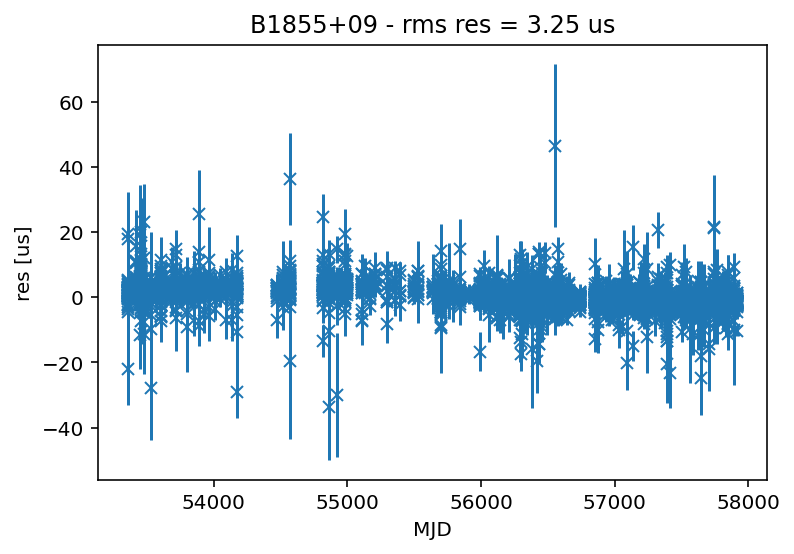

In [45]:
psr = libstempo.tempopulsar(parfile = '/Users/brendandrachler/Documents/code_dev/NANOGrav_12y/par/B1855+09_NANOGrav_12yv2.gls.par',
                    timfile = '/Users/brendandrachler/Documents/code_dev/NANOGrav_12y/tim/B1855+09_NANOGrav_12yv2.tim')
LP.plotres(psr)

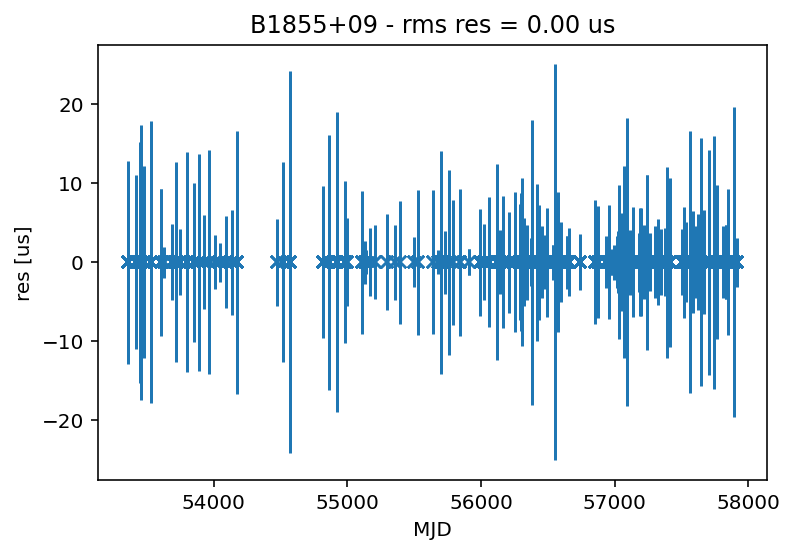

In [46]:
LT.make_ideal(psr)
LP.plotres(psr)

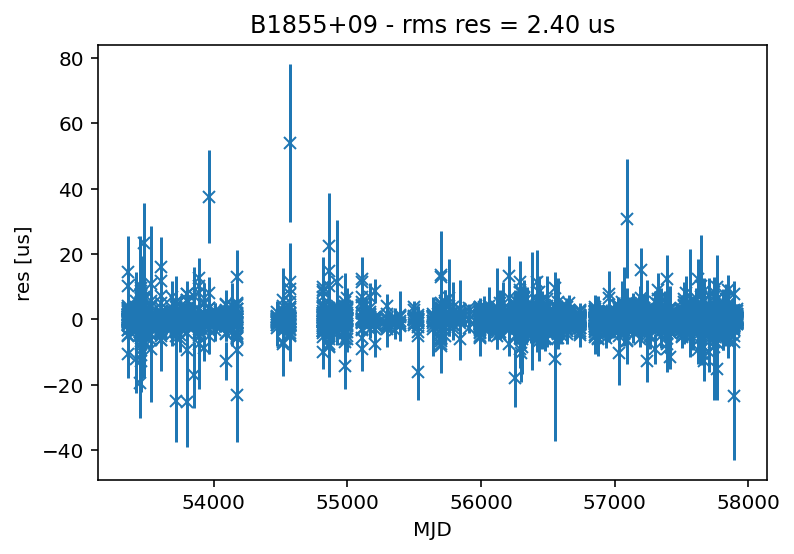

In [47]:
LT.add_efac(psr,efac=1.0,seed=1234)
LP.plotres(psr)

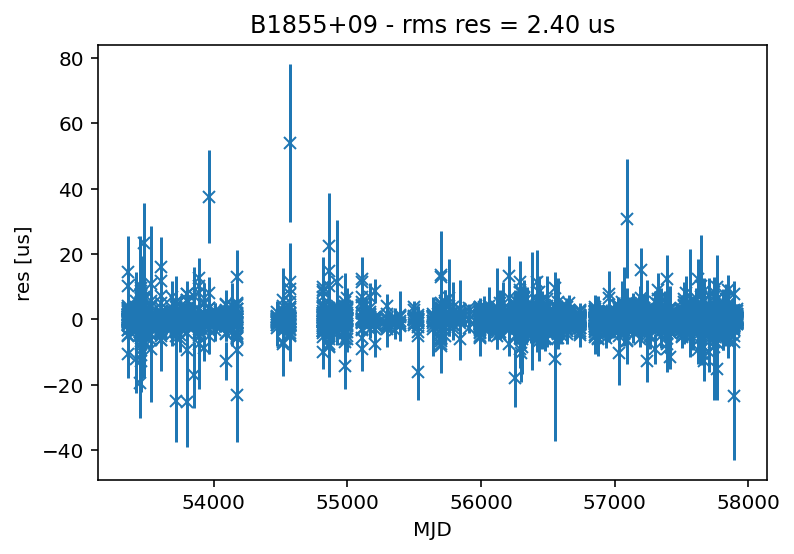

In [48]:
LT.add_fdm(psr, 1e-15, 1e-8, np.pi, np.pi/2)
LP.plotres(psr)

In [21]:
A = 1e-15
f = 1e-8
phase_e = np.pi
phase_p = np.pi/2
res = - A / (2 * np.pi * f) * (np.sin(2 * np.pi * f * psr.toas() + phase_e) - np.sin(2 * np.pi * f * psr.toas() + phase_p))

psr.stoas[:] += res/86400

In [13]:
A / (2 * np.pi * f)

1.5915494309189534e-08

In [20]:
2 * np.pi * f * psr.toas() + phase_e

array([3.14494528, 3.14494528, 3.14494528, ..., 3.14523158, 3.14523158,
       3.14523158], dtype=float128)

In [19]:
psr.toas()

array([53358.72366849, 53358.72366849, 53358.72366849, ...,
       57915.28012679, 57915.28012685, 57915.28012691], dtype=float128)

fake_fdm_only_dataset/
